# Working with DALI

## Install wheel file

In [1]:
!pip install --force-reinstall *.whl

Processing ./cuclara_image-0.2.0-py3-none-manylinux2014_x86_64.whl
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: cuclara-image
    Found existing installation: cuclara-image 0.2.0
    Uninstalling cuclara-image-0.2.0:
      Successfully uninstalled cuclara-image-0.2.0


## Install matplotlib

In [2]:
!pip install matplotlib

## Interoperability with DALI through Python Custom Operator

<https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/python_operator.html#>

In [3]:
from cucim import CuImage

import numpy as np

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import numpy as np

def filter_images(image):
    # Filter with CuImage's filter methods (future work)
    #   example)
    #     from cucim import filters
    #     filtered_image = filters.sobel(image)
    filtered_image = image
    return filtered_image

def gen_image(file_name, location_list, size_list, level_list, batch_size):
    image = CuImage(file_name)
    batch = []
    for location, size, level in zip(location_list, size_list, level_list):
        region = image.read_region(location=location, size=size, level=level)
        batch.append(np.asarray(region))
        if (len(batch) == batch_size):
            yield (batch,)
            batch = []

class DPLoaderPipeline(Pipeline):
    def __init__(self, file_name, location_list, size_list, level_list, batch_size, num_threads, device_id):
        super(DPLoaderPipeline, self).__init__(batch_size, num_threads, device_id, exec_async=False,
                                             exec_pipelined=False, seed=99)
        self.input = ops.ExternalSource(
            source=gen_image(file_name, location_list, size_list, level_list, batch_size), num_outputs=1
        )
        self.filter = ops.PythonFunction(function=filter_images, num_outputs=1)
        self.resize = ops.Resize(resize_x=500, resize_y=500)

    def define_graph(self):
        image = self.input()
        filtered_image = self.filter(image[0])
        return self.resize(filtered_image)
    

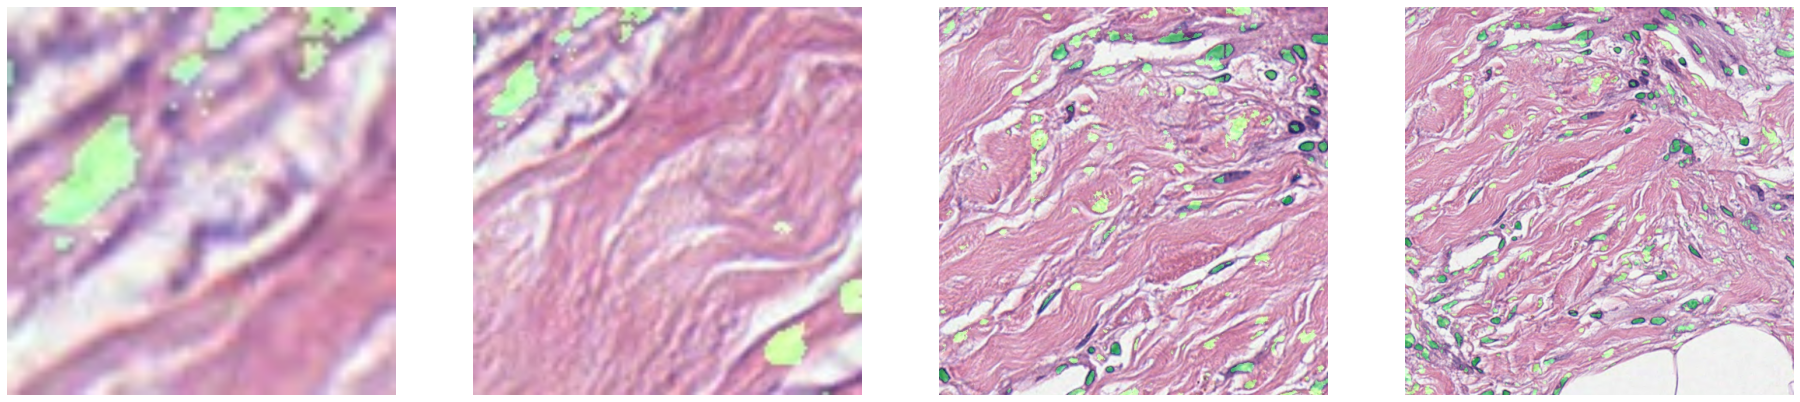

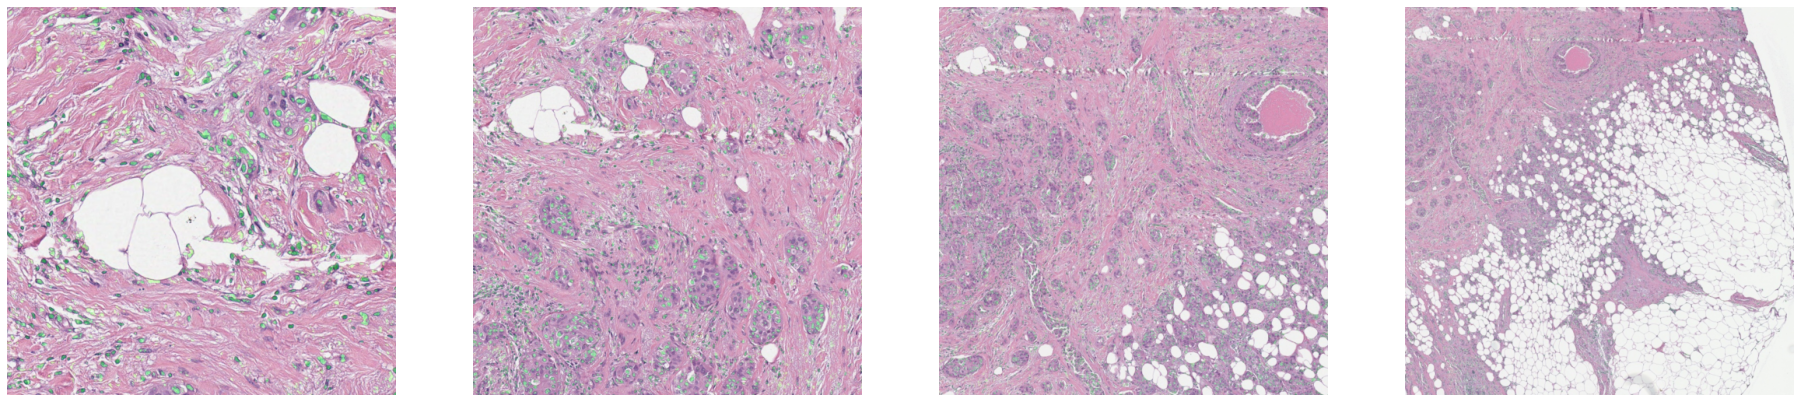

In [4]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 4

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

file_name = "input/image.tif"
location_list = [    (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000), (5000, 5000)]
size_list     = [        (64, 64),   (128, 128),   (512, 512),   (800, 800),   (800, 800),   (800, 800),   (800, 800),   (800, 800)]
level_list    = [               0,            0,            0,            0,           1,             2,            3,            4]

num_threads = 1
pipe = DPLoaderPipeline(file_name, location_list, size_list, level_list, batch_size, num_threads, 0)
pipe.build()

while True:
    try:
        output = pipe.run()        
        show_images(output[0])
    except StopIteration:
        break
        

### Limitations of Python operators

<https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/python_operator.html#Limitations-of-Python-Operators>

> As we could see, pipelines that incorporate Python operators has to be constructed with `exec_async=False` and `exec_pipelined=False` specified. It was necesary to make it possible to call Python code from inside of DALI but it hits the performance of data pipelines. In addition to that, Python operators cannot utilize more than one CPU core due to Python threading model. Taking all that into account, Python operators can be very useful for testing, debugging or prototyping, but are not considered as a production level solution for extending DALI.

## Interoperability with DALI through C++ Plugin (future work)

<https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/custom_operations/custom_operator/create_a_custom_operator.html#Operator-Definition>

By linking cuCIM's C++ library, we can make universal cuCIM adaptors for `cucim::io::format::IImageFormat` (image file loading/saving) and `cucim::filter::IImageFilter` (image filtering) interfaces.

**Example**

```python
import nvidia.dali.plugin_manager as plugin_manager
plugin_manager.load_library('./cucim-adaptor/build/libcucim_format.so') # CuImageReader/CuImageWriter
plugin_manager.load_library('./cucim-adaptor/build/libcucim_filter.so') # CuImageFilter

import nvidia.dali.ops as ops

image_dir = "data/images"
batch_size = 2

class CuImagePipeline(Pipeline):
    def __init__(self, file_list, params_list, label_list, batch_size, num_threads, device_id):
        super(CuImagePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.image = ops.CuImageReader(file_list, params_list, labels=label_list, device = 'cpu')
        self.filter = ops.CuImageFilter("sobel", axis=1, mode='reflect')

    def define_graph(self):
        images, labels = self.image()
        filtered_images = self.filter(images)
        return (filtered_images, labels)

# Input list (can use generator/iterator)
file_list   = ["input/image.tif", "input/image2.tif"]
params_list = [{'location': (100, 100), 'size': (256, 256), 'level': 0}, {'location': (500, 500), 'size': (256, 256), 'level': 1}]
label_list  = ['tumor', 'tissue']

num_threads = 1
pipe = CuImagePipeline(file_list, params_list, label_list, batch_size, num_threads, 0)
pipe.build()

output = pipe.run()
```


## TODO

- Support DALI's CPU/GPU Tensor: <https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#tensor>
- Provide universal cucim adaptors for DALI (for `cucim::io::format::IImageFormat` and `cucim::filter::IImageFilter` interfaces)